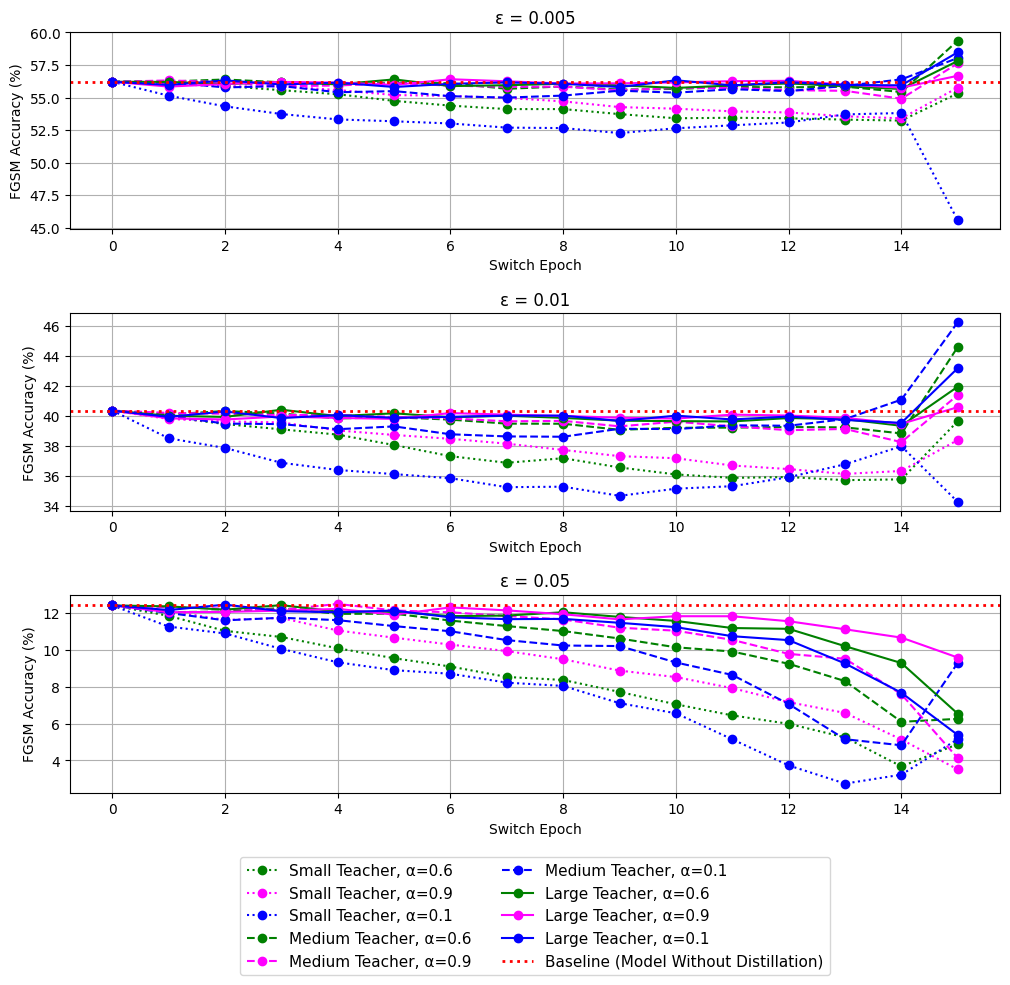

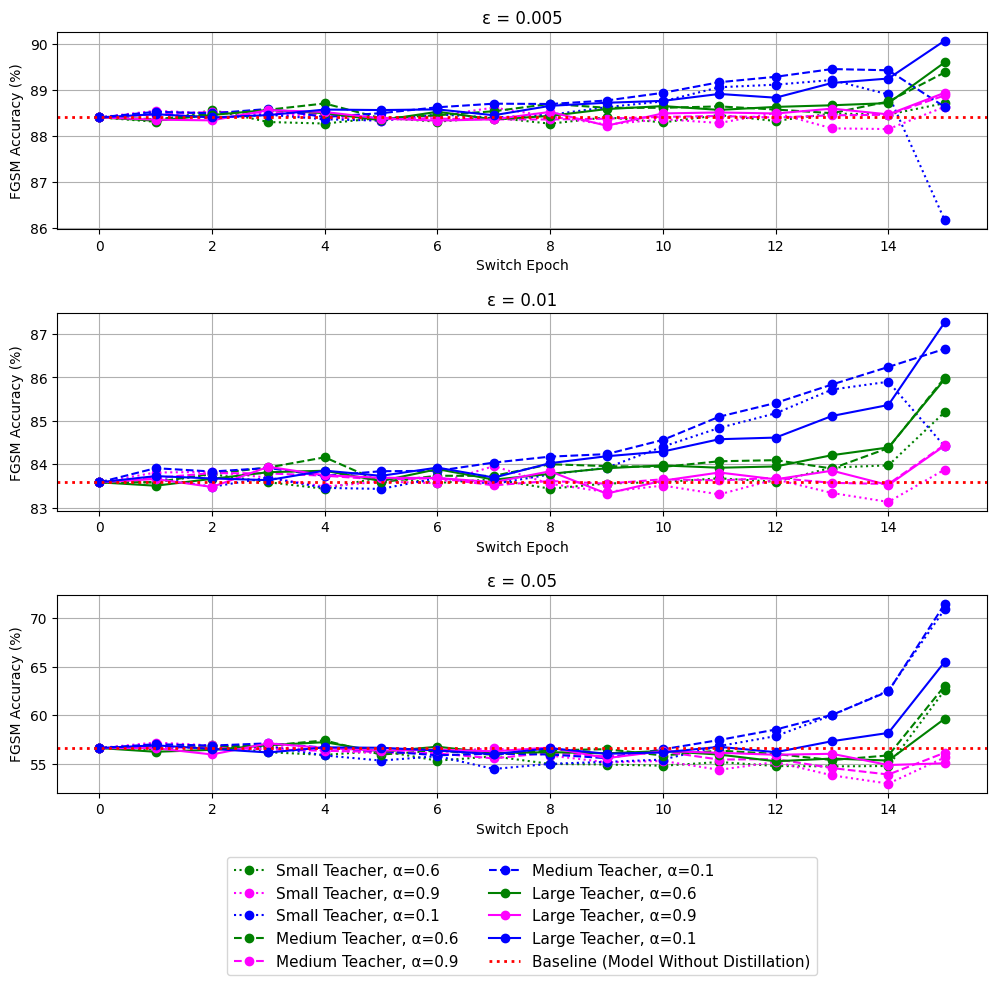

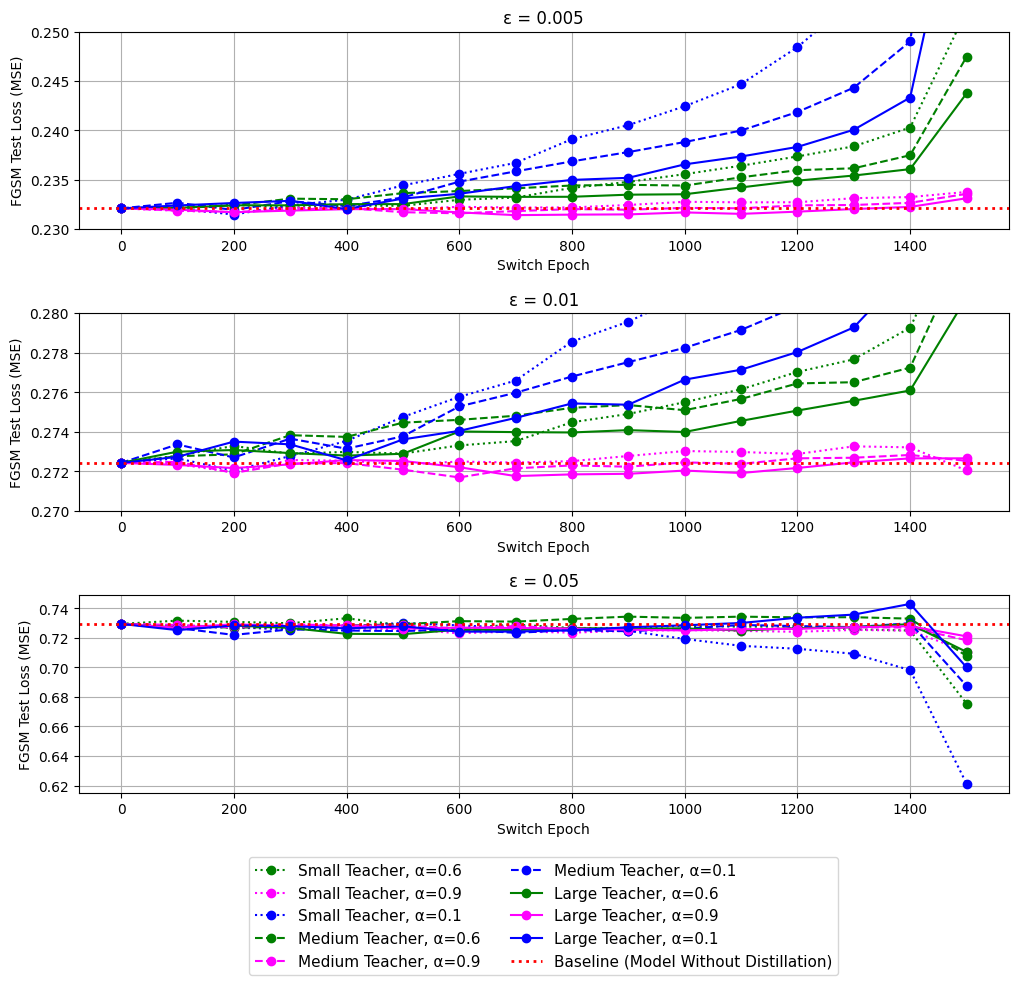

In [4]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict

output_dir = "../outputs"
seeds = np.loadtxt("../scripts/configs/seeds.txt", dtype=int).tolist()
target_epsilons = [0.005, 0.01, 0.05]
datasets = ["cifar", "fashion_mnist", "california_housing"]

for dataset in datasets:
    alpha_colors = {
        "0_1": "blue",
        "0_6": "green",
        "0_9": "magenta"
    }
    teacher_styles = {
        "small": "dotted",
        "medium": "dashed",
        "large": "solid"
    }

    experiment_dirs = sorted([d for d in os.listdir(output_dir) if d.startswith("experiment")],
                             key=lambda x: int(re.search(r'experiment(\d+)', x).group(1)))

    # === Figure se 3 subplota pod sebou ===
    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(4, 1, height_ratios=[1, 1, 1, 0.4], hspace=0.5)
    axs = [fig.add_subplot(gs[i]) for i in range(3)]
    all_lines = []

    for idx, target_epsilon in enumerate(target_epsilons):
        ax = axs[idx]
        results = {}

        for exp_dir in experiment_dirs:
            if f"{dataset}" not in exp_dir:
                continue

            match = re.match(rf"experiment\d+_alpha_(\d_\d)_(\w+)_{dataset}", exp_dir)
            if not match:
                continue

            alpha, teacher_size = match.groups()
            label = f"{teacher_size.capitalize()} Teacher, α={alpha.replace('_', '.')}"
            path = os.path.join(output_dir, exp_dir)

            switch_epoch_accs = defaultdict(list)

            for seed in seeds:
                seed_dir = os.path.join(path, f"seed_{seed}")
                if not os.path.exists(seed_dir):
                    continue

                for switch_epoch_dir in os.listdir(seed_dir):
                    if not switch_epoch_dir.startswith("switch_epoch_"):
                        continue

                    switch_epoch = int(switch_epoch_dir.split("_")[-1])
                    csv_path = os.path.join(seed_dir, switch_epoch_dir, "fgsm_results.csv")
                    if not os.path.exists(csv_path):
                        continue

                    try:
                        df = pd.read_csv(csv_path)
                        df["epsilon"] = df["epsilon"].astype(float)
                        acc_row = df[df["epsilon"] == target_epsilon]
                        if not acc_row.empty:
                            acc = acc_row["accuracy"].values[0]
                            switch_epoch_accs[switch_epoch].append(acc)
                    except Exception as e:
                        print(f"Chyba při čtení {csv_path}: {e}")

            if not switch_epoch_accs:
                print(f"Žádná data pro {label}, přeskočeno.")
                continue

            x_vals = sorted(switch_epoch_accs.keys())
            y_vals = [np.mean(switch_epoch_accs[x]) for x in x_vals]

            color = alpha_colors.get(alpha, "black")
            linestyle = teacher_styles.get(teacher_size, "solid")
            results[label] = (x_vals, y_vals, color, linestyle)

        # baseline
        baseline_vals = []
        for seed in seeds:
            student_csv = f"{output_dir}/student_{dataset}/model_seed_{seed}/fgsm_results.csv"
            if os.path.exists(student_csv):
                try:
                    df = pd.read_csv(student_csv)
                    df["epsilon"] = df["epsilon"].astype(float)
                    row = df[df["epsilon"] == target_epsilon]
                    if not row.empty:
                        baseline_vals.append(row["accuracy"].values[0])
                except Exception as e:
                    print(f"Chyba při čtení baseline: {e}")

        baseline_mean = np.mean(baseline_vals) if baseline_vals else None

        if baseline_mean is not None:
            for key in results:
                x_vals, y_vals, color, linestyle = results[key]
                if 0 not in x_vals:
                    x_vals.insert(0, 0)
                    y_vals.insert(0, baseline_mean)
                results[key] = (x_vals, y_vals, color, linestyle)

        lines = []
        for label, (x, y, color, linestyle) in results.items():
            line = ax.plot(x, y, label=label, color=color, linestyle=linestyle, marker='o')
            lines.append(line[0])

        if baseline_mean is not None:
            line = ax.axhline(y=baseline_mean, color='red', linestyle='dotted', linewidth=2,
                              label='Baseline (Model Without Distillation)')
            lines.append(line)

        ax.set_title(f"ε = {target_epsilon}")
        ax.set_xlabel("Switch Epoch")
        ax.grid(True)

        if dataset == "california_housing":
            ax.set_ylabel("FGSM Test Loss (MSE)")
            if target_epsilon == 0.005:
                ax.set_ylim(0.23, 0.25)
            elif target_epsilon == 0.01:
                ax.set_ylim(0.27, 0.28)
        else:
            ax.set_ylabel("FGSM Accuracy (%)")

        if idx == 2:
            all_lines = lines  # použijeme pro legendu

    # === Legenda v samostatném subplotu pod grafy ===
    legend_ax = fig.add_subplot(gs[3])
    legend_ax.axis("off")
    legend = legend_ax.legend(all_lines, [line.get_label() for line in all_lines],
                               loc='center', ncol=2, fontsize=11)

    #plt.suptitle(f"FGSM Accuracy vs. Switch Epoch – {dataset.capitalize()}", fontsize=16)
    plt.savefig(f"../graphs/fgsm/{dataset}_fgsm_summary_vertical.pdf", bbox_inches='tight')
    plt.show()
